In [ ]:
%load_ext autoreload
%autoreload 2

In [21]:
!pip install ..

Processing /home/clement/Project/PhyloRNN/phyloRNN
  Installing build dependencies ... one
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for phyloRNN: filename=phyloRNN-0.41-py3-none-any.whl size=463470 sha256=4a72b0d488f6d2d408119aac2c60a6a64997d316dbea2b363ef13081f219a3d9
  Stored in directory: /tmp/pip-ephem-wheel-cache-mvjdqgc_/wheels/75/e5/f0/f031af9f02ec3ccd69c626c59d0ff6d65beb97028c575e91bf
Successfully built phyloRNN
  Attempting uninstall: phyloRNN
    Found existing installation: phyloRNN 0.41
    Uninstalling phyloRNN-0.41:
      Successfully uninstalled phyloRNN-0.41


In [1]:
import os
import matplotlib.pyplot as plt
import phyloRNN as pn
import sqlite3
import zlib
import numpy as np
import json
import tensorflow as tt

2025-02-24 09:44:23.836595: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-24 09:44:23.841434: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.4/lib64:
2025-02-24 09:44:23.841453: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
print(tt.__version__)
print(np.__version__)

2.9.3
1.23.5


# Utils functions


In [27]:
def plot_size(sizes, label_x):
    # Extract keys and values
    keys = list(sizes.keys())
    values1 = [v[0] / (1024**2)  for v in sizes.values()]
    values2 = [v[1] / (1024**2)  for v in sizes.values()]
    
    # Plotting
    plt.plot(keys, values1, 'ro-', label='npz')
    plt.plot(keys, values2, 'bo-', label='sqlite')
    
    # Adding labels and title
    plt.xlabel(label_x)
    plt.ylabel('Mb')
    plt.title('Mb per #Sim')
    plt.legend()
    
    # Show plot
    plt.show()

def plot3d(sizes):
    import os
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    
    
    # Prepare data for plotting
    x = []
    y = []
    z1 = []
    z2 = []
    
    for sim_size, n_sites in sizes.items():
        for n_site, file_sizes in n_sites.items():
            x.append(sim_size)
            y.append(n_site)
            z1.append(file_sizes[0] / (1024**2))  # Convert to MB
            z2.append(file_sizes[1] / (1024**2))  # Convert to MB
    
    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot first set of values (red)
    ax.scatter(x, y, z1, c='r', marker='o', label='File size .npz (MB)')
    # Plot second set of values (blue)
    ax.scatter(x, y, z2, c='b', marker='^', label='File size .db (MB)')
    
    # Connect the dots as a grid
    for i in range(len(x)):
        for j in range(i + 1, len(x)):
            if x[i] == x[j]:
                ax.plot([x[i], x[j]], [y[i], y[j]], [z1[i], z1[j]], 'r-')
                ax.plot([x[i], x[j]], [y[i], y[j]], [z2[i], z2[j]], 'b-')
            if y[i] == y[j]:
                ax.plot([x[i], x[j]], [y[i], y[j]], [z1[i], z1[j]], 'r-')
                ax.plot([x[i], x[j]], [y[i], y[j]], [z2[i], z2[j]], 'b-')
    
    # Adding labels and title
    ax.set_xlabel('Simulation Size')
    ax.set_ylabel('Number of Sites')
    ax.set_zlabel('File Size (MB)')
    ax.set_title('3D Plot of Simulation Data')
    ax.legend()

    plt.xlim(left=0)
    plt.ylim(bottom=0)
    ax.set_zlim(bottom=0)


    
    
    # Show plot
    plt.show()

def plot_training_history(history, show=True, save_path=None):
    
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    if save_path:
        plt.savefig(save_path)
    if show:
        plt.show()

print(os.cpu_count())

16


# Compute size for #Sim & #Site

In [12]:
sizes = {sim:{n_site:[] for n_site in range(10,30, 10)} for sim in range(5,50, 5)}

sizes = {20:{30:[]}}

for sim_size in sizes.keys():

    for n_site in sizes[sim_size].keys():
        
        name = "../data/simulation-tmp/training_data_{}sim_{}sites_50taxa".format(sim_size*7, n_site)
    
        sim = pn.simulator(
           n_taxa = 50,
           n_sites = n_site,
           n_eigen_features = 3,
           min_rate = 0,  #
           freq_uncorrelated_sites = 0.5,
           freq_mixed_models = 0.05,
           store_mixed_model_info = True,
           tree_builder = 'nj',  # 'upgma'
           subs_model_per_block = False,  # if false same subs model for all blocks
           phyml_path = None,  # path to phyml and seq binaries
           seqgen_path = None, # if None, it will try to use
           ali_path = None,                                            # system-wide installed software
           DEBUG=False,
           verbose = False,
           CPUs = 7,
           n_sims = sim_size,
           data_name = name,
           base_seed = 1234,
           format_output='both')
        
        
        pn.simulate_parallel(sim, add_day_tag=False)
    
        sizes[sim_size][n_site] = [os.path.getsize(name + '.npz'), os.path.getsize(name + '.db')] 



Running ../data/simulation-tmp/training_data_140sim_30sites_50taxa
Running simulation 20 of 20 

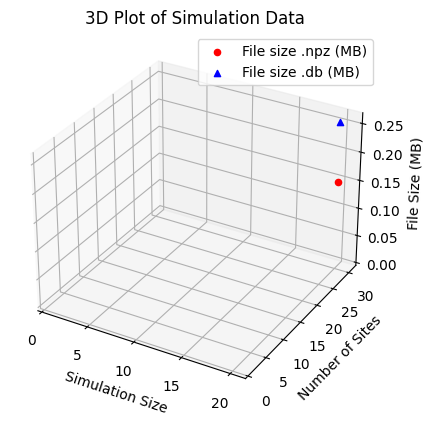

In [14]:
plot3d(sizes)

In [15]:
sizes

{20: {30: [159978, 270336]}}

# Explore Data Similarity npz <-> db 

In [30]:
simu = dict(np.load('../data/simulation-tmp/training_data_140sim_30sites_50taxa.npz', allow_pickle=True))
print(simu['labels_smodel'].shape)
print(simu['labels_smodel'])

(140,)
[1 2 2 2 1 1 0 1 1 1 0 1 0 1 0 1 1 1 0 2 2 1 1 1 1 0 0 0 1 2 0 0 0 2 0 1 2
 1 0 0 0 0 0 1 2 2 2 2 2 2 1 0 2 0 1 2 2 2 0 2 0 0 0 1 2 1 1 2 0 0 0 0 2 1
 1 0 0 1 1 2 2 1 0 0 0 1 2 0 1 1 0 2 2 1 1 1 0 1 0 1 0 1 2 1 1 0 0 1 1 1 2
 1 1 1 1 2 2 0 1 1 0 1 2 2 0 1 0 1 2 0 1 1 2 1 2 2 2 1 1 0]


In [32]:

def _decompdecode(e, dtype, shape ):
    return  np.frombuffer(zlib.decompress(e), dtype=dtype).reshape(shape[1:])

database = '../data/simulation-tmp/training_data_140sim_30sites_50taxa.db'

# Connect to the SQLite database
conn = sqlite3.connect(database)
cursor = conn.cursor()

# Query to get the list of all tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()



# Retrieve data from array_info table
cursor.execute('SELECT name_, dtype, shape FROM array_info')
rows = cursor.fetchall()

# Convert the retrieved data into a dictionary
array_info_dict = {}
for row in rows:
    name_, dtype, shape = row
    array_info_dict[name_] = {
        'dtype': dtype,
        'shape': eval(shape)  # Convert string representation of shape back to tuple
    }


# Query to get all rows from the simulation_data table
cursor.execute("SELECT labels_smodel FROM simulation")
 
datum = []
for row in cursor.fetchall():
   val = _decompdecode(row[0], array_info_dict['labels_smodel']['dtype'], array_info_dict['labels_smodel']['shape'])
   datum.append( val )



conn.close()

print(np.array(datum).shape)



(140,)


# Compatibility with rnn_in_out_dictionaries_from_sim and model training

In [64]:
sim, dict_inputs, dict_outputs = pn.rnn_in_out_dictionaries_from_sim('../data/simulation-tmp/training_data_140sim_30sites_50taxa.npz',
                                                                     log_rates=False,
                                                                     log_tree_len=True,
                                                                     output_list=['per_site_rate','tree_len'],
                                                                     include_tree_features=False)

sim2, dict_inputs2, dict_outputs2 = pn.rnn_in_out_dictionaries_from_sim('../data/simulation-tmp/training_data_140sim_30sites_50taxa.db',
                                                                     log_rates=False,
                                                                     log_tree_len=True,
                                                                     output_list=['per_site_rate','tree_len'],
                                                                     include_tree_features=False,
                                                                    sqlite = True)

(140, 30, 200)
(140, 30, 200)


In [65]:
for e in sim.keys():
    print(e)
    print(np.array(sim[e]).shape)
    print(np.array(sim2[e]).shape)
    #print(sim['features_tree'][0] == sim2['features_tree'][0])

features_ali
(140, 30, 200)
(140, 30, 200)
features_tree
(140, 150)
(140, 150)
labels_rates
(140, 30)
(140, 30)
labels_smodel
(140,)
(140,)
labels_tl
(140,)
(140,)
info
(140,)
(140,)


# Compatibility with training

In [24]:
def train(fn, sqlite, taxa, site):

    training_file = os.path.join(os.getcwd(), fn)
    wd = os.path.dirname(training_file)
    model_name = "t50_s20"
    
    # load data
    sim, dict_inputs, dict_outputs = pn.rnn_in_out_dictionaries_from_sim(training_file,
                                                                         log_rates=False,
                                                                         log_tree_len=True,
                                                                         output_list=['per_site_rate','tree_len'],
                                                                         include_tree_features=False,
                                                                        sqlite = sqlite)
    
    # setup model architecture
    model_config = pn.rnn_config(n_sites=site, n_taxa=taxa) # default settings
    
    # build model
    model = pn.build_rnn_model(model_config,
                               optimizer=pn.keras.optimizers.RMSprop(1e-3),
                               print_summary=False)
    
    
    # training
    early_stop = pn.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=5,
                                                  restore_best_weights=True)
    
    history = model.fit(dict_inputs, dict_outputs,
                        epochs=1000,
                        validation_split=0.2,
                        verbose=2,
                        callbacks=[early_stop],
                        batch_size=100)
    
    # save model
    pn.save_rnn_model(wd=wd, history=history, model=model, filename=model_name)

    return history

def simulate():
    
    sim = pn.simulator(
                   n_taxa = 50,
                   n_sites = 1000,
                   n_eigen_features = 3,
                   min_rate = 0,  #
                   freq_uncorrelated_sites = 0.5,
                   freq_mixed_models = 0.05,
                   store_mixed_model_info = True,
                   tree_builder = 'nj',  # 'upgma'
                   subs_model_per_block = False,  # if false same subs model for all blocks
                   phyml_path = None,  # path to phyml and seq binaries
                   seqgen_path = None, # if None, it will try to use
                   ali_path = None,                                            # system-wide installed software
                   DEBUG=False,
                   verbose = False,
           format_output='both')


        # training set
    sim.reset_prms(CPUs = 6,
                   n_sims = 100,
                   data_name = "training_data",
                   base_seed = 1234)
    pn.simulate_parallel(sim, add_day_tag=False)

    # test set
    sim.reset_prms(CPUs = 1,
                   n_sims = 20,
                   data_name = "test_data",
                   run_phyml = True,
                   base_seed = 4321)
    pn.simulate_parallel(sim, add_day_tag=False)


In [25]:
history_npz = train('../data/simulation-tmp/training_data_140sim_30sites_50taxa.npz', False, 50,30)

Creating blocks...
t1
<KerasTensor shape=(None, 1, 128), dtype=float32, sparse=False, name=keras_tensor_226>
<KerasTensor shape=(None, 1, 128), dtype=float32, sparse=False, name=keras_tensor_227>
<KerasTensor shape=(None, 1, 128), dtype=float32, sparse=False, name=keras_tensor_228>
<KerasTensor shape=(None, 1, 128), dtype=float32, sparse=False, name=keras_tensor_229>
<KerasTensor shape=(None, 1, 128), dtype=float32, sparse=False, name=keras_tensor_230>
<KerasTensor shape=(None, 1, 128), dtype=float32, sparse=False, name=keras_tensor_231>
<KerasTensor shape=(None, 1, 128), dtype=float32, sparse=False, name=keras_tensor_232>
<KerasTensor shape=(None, 1, 128), dtype=float32, sparse=False, name=keras_tensor_233>
<KerasTensor shape=(None, 1, 128), dtype=float32, sparse=False, name=keras_tensor_234>
<KerasTensor shape=(None, 1, 128), dtype=float32, sparse=False, name=keras_tensor_235>
<KerasTensor shape=(None, 1, 128), dtype=float32, sparse=False, name=keras_tensor_236>
<KerasTensor shape=(N

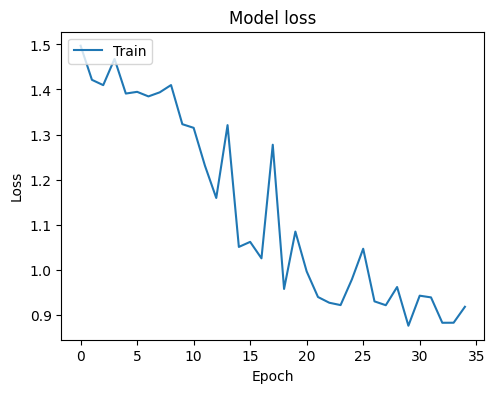

In [28]:
plot_training_history(history_npz)

In [70]:
history_db =train('../data/simulation-tmp/training_data_140sim_30sites_50taxa.db', True, 50,30)

(140, 30, 200)
Creating blocks...
done
N. model parameters: 520195
Epoch 1/1000
2/2 - 12s - loss: 1.6341 - per_site_rate_loss: 0.8757 - tree_len_loss: 0.7584 - val_loss: 1.4632 - val_per_site_rate_loss: 0.7353 - val_tree_len_loss: 0.7279 - 12s/epoch - 6s/step
Epoch 2/1000
2/2 - 0s - loss: 1.6236 - per_site_rate_loss: 0.8799 - tree_len_loss: 0.7436 - val_loss: 1.4869 - val_per_site_rate_loss: 0.7295 - val_tree_len_loss: 0.7573 - 104ms/epoch - 52ms/step
Epoch 3/1000
2/2 - 0s - loss: 1.5875 - per_site_rate_loss: 0.8718 - tree_len_loss: 0.7157 - val_loss: 1.6338 - val_per_site_rate_loss: 0.7303 - val_tree_len_loss: 0.9035 - 98ms/epoch - 49ms/step
Epoch 4/1000
2/2 - 0s - loss: 1.6632 - per_site_rate_loss: 0.8694 - tree_len_loss: 0.7938 - val_loss: 1.4316 - val_per_site_rate_loss: 0.7292 - val_tree_len_loss: 0.7023 - 101ms/epoch - 50ms/step
Epoch 5/1000
2/2 - 0s - loss: 1.5902 - per_site_rate_loss: 0.8680 - tree_len_loss: 0.7222 - val_loss: 1.4169 - val_per_site_rate_loss: 0.7313 - val_tree_

INFO:tensorflow:Assets written to: /home/clement/Project/PhyloRNN/phyloRNN/notebooks/../data/simulation-tmp/t50_s20_model/assets


INFO:tensorflow:Assets written to: /home/clement/Project/PhyloRNN/phyloRNN/notebooks/../data/simulation-tmp/t50_s20_model/assets


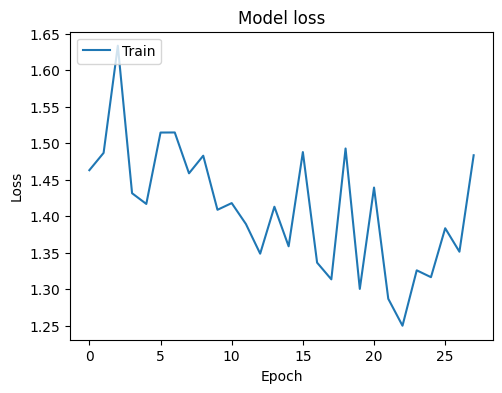

In [71]:
plot_training_history(history_db)